# gp2Scale 
gp2Scale is a special setting in fvgp that combines non-stationary, compactly-supported kernels, HPC distributed computing, and sparse linear algebra to allow scale-up of exact GPs to millions of data points. gp2Scale holds the world record in this category! Here we run a moderately-sized GP, just because we assume you might run this locally.

I hope it is clear how cool it is what is happening here. If you have a dask client that points to a remote cluster with 500 GPUs, you will distribute the covariance matrix computation across those. The full matrix is sparse and will be fast to work with in downstream operations. The algorithm only makes use of naturally-occuring sparsity, so the result is exact in contrast to Vecchia or inducing-point methods.

In [7]:
##first install the newest version of fvgp
#!pip install fvgp~=4.6.0
#!pip install imate

## Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
from dask.distributed import Client
import sys
%load_ext autoreload
%autoreload 2

#further control plotting 
from loguru import logger
logger.disable("fvgp")


client = Client() ##this is the client you can make locally like this or 
#your HPC team can provide a script to get it. We included an example to get gp2Scale going
#on Perlmutter


#It's good practice to make sure to wait for all the workers to be ready
client.wait_for_workers(4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the data and some other inputs

In [9]:
def f1(x):
    return ((np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)))

input_dim = 1
N = 2000
x_data = np.random.rand(N,input_dim)
y_data = f1(x_data).reshape(len(x_data))
hps_n = 2

hps_bounds = np.array([[0.1,1.],      ##signal var of Wendland kernel
                       [0.001,0.04]])  ##length scale for Wendland kernel

In [10]:
from fvgp.kernels import wendland_anisotropic_gp2Scale_cpu
def kernel(x1,x2,hps):
    return wendland_anisotropic_gp2Scale_cpu(x1,x2,hps)


init_hps = np.array([0.73118673, 0.13813191])
my_gp2S = GP(x_data,y_data, kernel_function=kernel, 
             init_hyperparameters = init_hps, #compute_device = 'gpu', #you can use gpus here
             gp2Scale = True, gp2Scale_batch_size= 1000, 
             gp2Scale_dask_client = client, gp2Scale_linalg_mode= "Chol",)

my_gp2S.train(hyperparameter_bounds = hps_bounds, max_iter = 20)



array([0.62416514, 0.02094628])

In [11]:
from fvgp.gpMCMC import ProposalDistribution
init_s = (np.diag(hps_bounds[:,1]-hps_bounds[:,0])/100.)**2


def obj_func(hps,args):
    return my_gp2S.log_likelihood(hyperparameters=hps[0:2])

from fvgp import gpMCMC
def proposal_distribution(x0, hps, obj):
    cov = obj.prop_args["prop_Sigma"]
    proposal_hps = np.zeros((len(x0)))
    proposal_hps = np.random.multivariate_normal(
        mean = x0, cov = cov, size = 1).reshape(len(x0))
    return proposal_hps

def in_bounds(v,bounds):
    if any(v<bounds[:,0]) or any(v>bounds[:,1]): return False
    return True
def prior_function(theta,args):
    bounds = args["bounds"]
    if in_bounds(theta, bounds): 
        return 0. + np.sum(np.log(theta)/2.)
    else: 
        return -np.inf
pd = ProposalDistribution([0,1] ,proposal_dist=proposal_distribution,
                        init_prop_Sigma = init_s, adapt_callable="normal")

my_mcmc = gpMCMC(obj_func, prior_function, [pd],
                args={"bounds":hps_bounds})
logger.disable("fvgp")
hps = np.random.uniform(
                        low = hps_bounds[:,0], 
                        high = hps_bounds[:,1], 
                        size = len(hps_bounds))
mcmc_result = my_mcmc.run_mcmc(x0=hps, n_updates=110, break_condition="default", info = True)

my_gp2S.set_hyperparameters(mcmc_result["x"][-1])

Starting likelihood. f(x)=  6108.9590978418655
Finished  100  out of  110  iterations. f(x)=  6564.544191722808


## Posterior evaluation

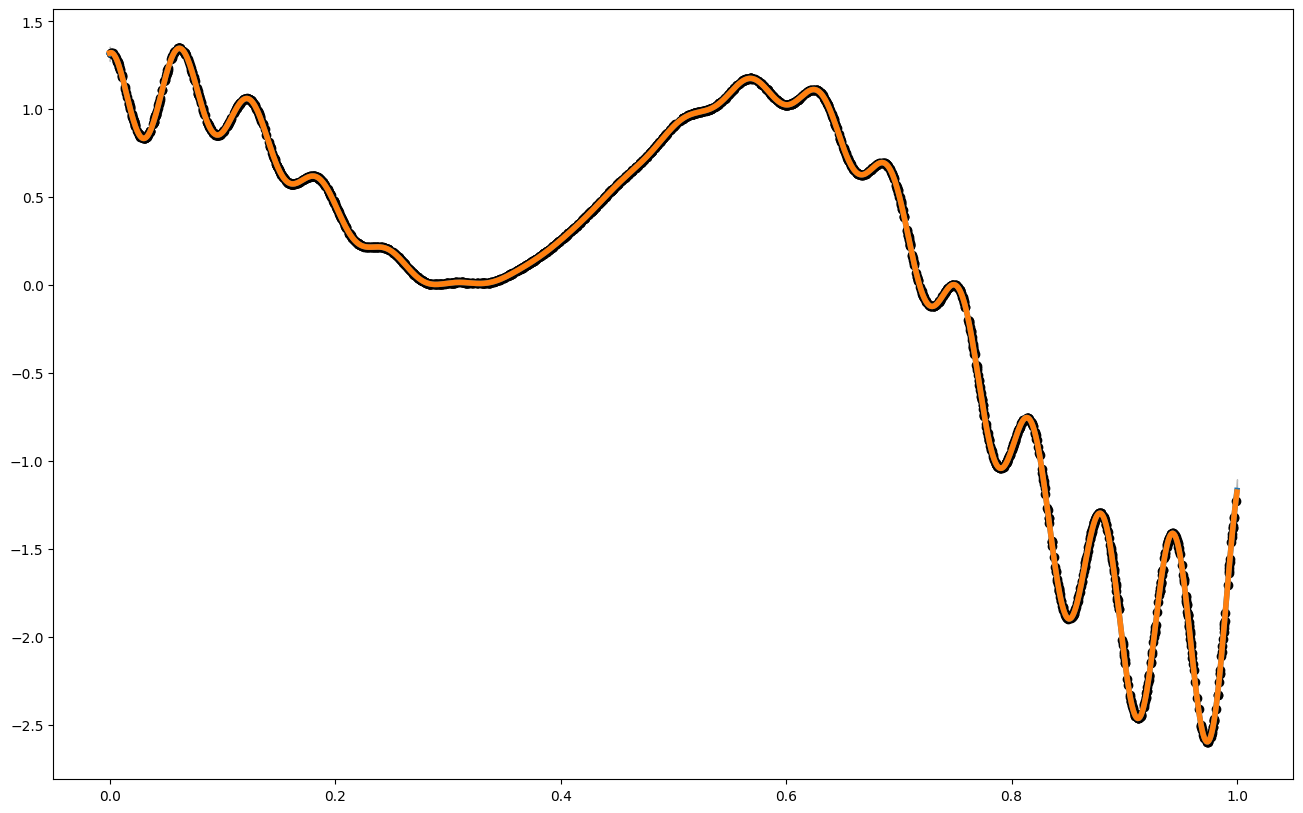

In [12]:
x_pred = np.linspace(0,1,1000) ##for big GPs, this is usually not a good idea, but in 1d, we can still do it
                               ##It's better to do predictions only for a handful of points at a time.

mean1 = my_gp2S.posterior_mean(x_pred.reshape(1000,1))["m(x)"]
var1 =  my_gp2S.posterior_covariance(x_pred.reshape(1000,1), variance_only=False)["v(x)"]


plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')